# Cartpole

## Tutorial
https://www.anyscale.com/blog/an-introduction-to-reinforcement-learning-with-openai-gym-rllib-and-google

In [11]:
import torch
from IPython.display import clear_output
from IPython import display
import random
import matplotlib.pylab as plt
import copy
import gym
import matplotlib.pyplot as plt

env = gym.make("CartPole-v0")

In [12]:
env.action_space

Discrete(2)

In [3]:
env.reset()

array([ 0.04072718,  0.04374892, -0.01956364, -0.00705616], dtype=float32)

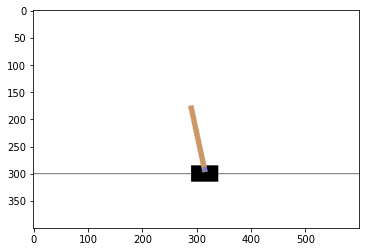

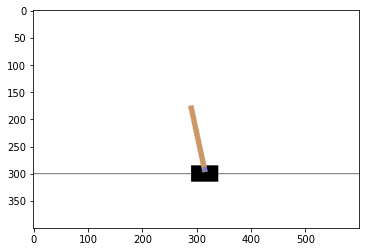

In [4]:
import time
state = env.reset()
done = False
i = 0
while not done:
    plt.cla()
    
    state, reward, done, _ = env.step(env.action_space.sample())

    plt.imshow(env.render(mode="rgb_array"))
    time.sleep(0.1)
    i = i+ 1
    print(i)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.gcf()

In [ ]:
import ray
from ray.rllib.agents.ppo import PPOTrainer
config = {
    "env": "CartPole-v0",
    # Change the following line to `“framework”: “tf”` to use tensorflow
    "framework": "torch",
    "model": {
      "fcnet_hiddens": [32],
      "fcnet_activation": "linear",
    },
}
stop = {"episode_reward_mean": 195}
ray.shutdown()
ray.init(
  num_cpus=3,
  include_dashboard=False,
  ignore_reinit_error=True,
  log_to_driver=False,
)
# execute training 
analysis = ray.tune.run(
  "PPO",
  config=config,
  stop=stop,
  checkpoint_at_end=True,
)

In [6]:
# restore a trainer from the last checkpoint
trial = analysis.get_best_logdir("episode_reward_mean", "max")
checkpoint = analysis.get_best_checkpoint(
  trial,
  "training_iteration",
  "max",
)
trainer = PPOTrainer(config=config)
trainer.restore(checkpoint)

2022-06-27 12:31:10,299	INFO ppo.py:414 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-06-27 12:31:10,300	INFO trainer.py:903 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-06-27 12:31:11,764	INFO trainable.py:588 -- Restored on 10.13.62.8 from checkpoint: /home/ajit.kumar@SNU.IN/ray_results/PPO/PPO_CartPole-v0_9525c_00000_0_2022-06-27_12-28-43/checkpoint_000040/checkpoint-40
2022-06-27 12:31:11,764	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 127.22548985481262, '_episodes_total': 1366}


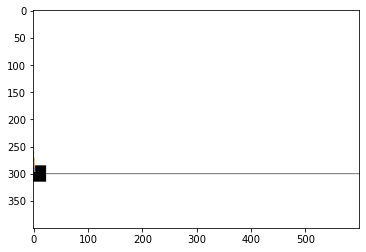

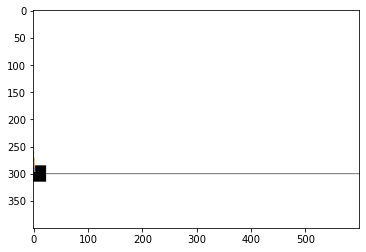

In [10]:
import time
state = env.reset()
done = False
i = 0
while not done:
    plt.cla()

    action = trainer.compute_action(state)
    state, reward, done, _ = env.step(action)
    i = i+1
    print(i)
    plt.imshow(env.render(mode="rgb_array"))
    time.sleep(0.01)

    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.gcf()
    
env.close()

In [ ]:
parameter_search_config = {
    "env": "CartPole-v0",
    "framework": "torch",

    # Hyperparameter tuning
    "model": {
      "fcnet_hiddens": ray.tune.grid_search([[32], [64]]),
      "fcnet_activation": ray.tune.grid_search(["linear", "relu"]),
    },
    "lr": ray.tune.uniform(1e-7, 1e-2)
}

# To explicitly stop or restart Ray, use the shutdown API.
ray.shutdown()

ray.init(
  num_cpus=12,
  include_dashboard=False,
  ignore_reinit_error=True,
  log_to_driver=False,
)

parameter_search_analysis = ray.tune.run(
  "PPO",
  config=parameter_search_config,
  stop=stop,
  num_samples=5,
  metric="timesteps_total",
  mode="min",
)

print(
  "Best hyperparameters found:",
  parameter_search_analysis.best_config,
)

In [19]:
print(
  "Best hyperparameters found:",
  parameter_search_analysis.best_config,
)

Best hyperparameters found: {'env': 'CartPole-v0', 'framework': 'torch', 'model': {'fcnet_hiddens': [32], 'fcnet_activation': 'relu'}, 'lr': 0.002069047627722433}


# Env: Simple Corridor

In [10]:
import gym
import ray
from ray.rllib.agents.ppo import PPOTrainer


# Define your problem using python and openAI's gym API:
class SimpleCorridor(gym.Env):
    """Corridor in which an agent must learn to move right to reach the exit.

    ---------------------
    | S | 1 | 2 | 3 | G |   S=start; G=goal; corridor_length=5
    ---------------------

    Possible actions to chose from are: 0=left; 1=right
    Observations are floats indicating the current field index, e.g. 0.0 for
    starting position, 1.0 for the field next to the starting position, etc..
    Rewards are -0.1 for all steps, except when reaching the goal (+1.0).
    """

    def __init__(self, config):
        self.end_pos = config["corridor_length"]
        self.cur_pos = 0
        self.action_space = gym.spaces.Discrete(2)  # left and right
        self.observation_space = gym.spaces.Box(0.0, self.end_pos, shape=(1,))

    def reset(self):
        """Resets the episode and returns the initial observation of the new one."""
        self.cur_pos = 0
        # Return initial observation.
        return [self.cur_pos]

    def step(self, action):
        """Takes a single step in the episode given `action`

        Returns:
            New observation, reward, done-flag, info-dict (empty).
        """
        # Walk left.
        if action == 0 and self.cur_pos > 0:
            self.cur_pos -= 1
        # Walk right.
        elif action == 1:
            self.cur_pos += 1
        # Set `done` flag when end of corridor (goal) reached.
        done = self.cur_pos >= self.end_pos
        # +1 when goal reached, otherwise -1.
        reward = 1.0 if done else -0.1
        return [self.cur_pos], reward, done, {}


# Create an RLlib Trainer instance.
trainer = PPOTrainer(
    config={
        # Env class to use (here: our gym.Env sub-class from above).
        "env": SimpleCorridor,
        "framework": "torch",
        # Config dict to be passed to our custom env's constructor.
        "env_config": {
            # Use corridor with 20 fields (including S and G).
            "corridor_length": 20
        },
        # Parallelize environment rollouts.
        "num_workers": 8,
    }
)

# Train for n iterations and report results (mean episode rewards).
# Since we have to move at least 19 times in the env to reach the goal and
# each move gives us -0.1 reward (except the last move at the end: +1.0),
# we can expect to reach an optimal episode reward of -0.1*18 + 1.0 = -0.8
for i in range(5):
    results = trainer.train()
    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")

# Perform inference (action computations) based on given env observations.
# Note that we are using a slightly different env here (len 10 instead of 20),
# however, this should still work as the agent has (hopefully) learned
# to "just always walk right!"
env = SimpleCorridor({"corridor_length": 10})
# Get the initial observation (should be: [0.0] for the starting position).
obs = env.reset()
done = False
total_reward = 0.0
# Play one episode.
while not done:
    # Compute a single action, given the current observation
    # from the environment.
    action = trainer.compute_single_action(obs)
    # Apply the computed action in the environment.
    obs, reward, done, info = env.step(action)
    # Sum up rewards for reporting purposes.
    total_reward += reward
# Report results.
print(f"Played 1 episode; total-reward={total_reward}")

2022-06-27 13:48:14,380	WARNING ppo.py:386 -- `train_batch_size` (4000) cannot be achieved with your other settings (num_workers=8 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 500.
(RolloutWorker pid=1050900) 2022-06-27 13:48:15,818	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=1050900) /home/ajit.kumar@SNU.IN/anaconda3/envs/udemy-rl/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=1050900)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=1050898) 2022-06-27 13:48:15,817	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictio

Iter: 0; avg. reward=-22.28571428571437
Iter: 1; avg. reward=-10.884375000000036
Iter: 2; avg. reward=-3.258
Iter: 3; avg. reward=-2.390265486725665
Iter: 4; avg. reward=-1.8335714285714297
Played 1 episode; total-reward=1.1102230246251565e-16


In [9]:
trainer.stop()

In [12]:
ray.shutdown()